# Adjacency complex filtration

Given a 2D image of pavement cells, we can filter it by cell area or convexity and compute a persistence diagram to topologically describe the pattern. 

Relevant literature:

- M. Feng and M. Porter (2021) **Persistent Homology of Geospatial Data: A Case Study with Voting**. [DOI: 10.1137/19M1241519](https://doi.org/10.1137/19M1241519)
- FK. Clark, G. Weissbart, X. Wang, K. Harline, C-B. Li, P. Formosa-Jordan, AHK Roeder (2024) **A common pathway controls cell size in the sepal and leaf epidermis leading to a non-random pattern of giant cells.** [DOI: 10.1101/2024.07.26.605215](https://doi.org/10.1101/2024.07.26.605215)

## Extending images

One of the goals is to filter the images via adjacency complexes. These complexes, by construction, fail to detect holes when these are at the edge of the image/map. This could be an issue if a large-valued cell happens to touch the image's edge. The image thus will be extended (mirrored along its edges). Naturally, cells at the edge will now double in size or even quadruple for those at the corner! New will show up. These issues can distort our downstream analyses.

To prevent distortions, we'll keep track of two sets of values:
- The true values derived from the original image.
- The new values derived from the extended image.

We will also keep track of which cells are completely false (mirrored, not just extended).

In the end, we will only keep the true values for the original cells, and the mirrored cells will share the exact same values as their real counterparts.

## The script

- Load necessary packages. 

Just the basics are necessary. `json`, `os` and `glob` come by default. `Numpy`, `scipy`, `matplotlib`, and `pandas` are pretty standard.

I like `tifffile` to load TIFF images, but other options may be available. 


In [59]:
import glob
import os
import json
import copy
from importlib import reload
import tifffile as tf
import numpy as np
import pandas as pd
import networkx as nx
from scipy import ndimage

import matplotlib.pyplot as plt
import gudhi as gd

import matplotlib as mpl
import utils

# List of color-blind friendly colors
wong = ['#e69f00','#56b4e9','#757575','#009e73','#f0e442','#999999', '#0072b2','#d55e00','#cc79a7', '#cccccc']

## Load the data from a source directory `src`

- All the data files are insidea a `data` directory
- Each tissue/variant is its own folder
- We do `glob.glob` to get automatically the name of all the folders
- For example, the 3rd source folder `sidx = 3` corresponds to `../results/sepal/`

### Define a destination directory `dst`

- For consistency, the `results` folder should have the same structure as the `data` one.
- If the folder, say `../results/sepal/` is not existent, we can make it automatically

In [60]:
filesrcs = sorted(glob.glob(os.pardir + os.sep + 'data' + os.sep + '*' + os.sep))
filesrcs

['../data/leaf_25d_WT2/',
 '../data/leaf_25d_WT4/',
 '../data/leaf_25d_WT4_random/',
 '../data/sepal/',
 '../data/sepal_random/']

In [61]:
sidx = 0

src = filesrcs[sidx]
dst = os.pardir + os.sep + 'results' + os.sep + os.path.dirname(src).split(os.sep)[-1] + os.sep
print(dst)

../results/leaf_25d_WT2/


## Load the data

- Make a list of all the `.tiff` and `.tif` files inside the source folder.
- This is convenient for the random folders that contain several images

In [68]:
tifffiles = sorted(glob.glob(src + '*.tif*'))
print(tifffiles)

tidx = 0
bname, _ = os.path.splitext(os.path.split(tifffiles[tidx])[1])
print(tidx, bname, sep='\t')

# Load the raw image
img = tf.imread(tifffiles[tidx])

# Get the same pad values of each axis
pady,padx = np.round(0.5*np.asarray(img.shape)).astype(int)

# Largest cell label
maxcell = img.max()

# bounding boxes for each cell
css = ndimage.find_objects(img)

['../data/leaf_25d_WT2/segmentation.tiff']
0	segmentation


- Load the extended metadata: no need to recompute the actual extended image
- Make dictionaries with keys corresponding to node labels: these will help plot the graphs
    - `imgpos` Values corresponding to the cells' centers of mass (in the original image)
    - `gpos` values corresponding to centers of mass in the extended image
- Define a colormap `cmap` so different cells will have different colors (kind of)
- Load neighbor information `neighbors`

In [63]:
datafile = src + bname + '_extended_metadata.csv'
print(datafile)
data = pd.read_csv(datafile).set_index('Label')

foo = ['#f0f0f0'] + np.tile(wong, len(data)+2).tolist()
cmap = mpl.colors.ListedColormap(foo[:len(data)+1])
imgpos = dict(zip(range(1,len(data)+1), data[['centerX', 'centerY']].to_numpy())) 
gpos = dict(zip(range(1,len(data)+1), data[['extcenterX', 'extcenterY']].to_numpy()))

datafile = src + bname + '_extended_neighbors.json'
print(datafile)
with open(datafile, "r") as f:
    neighbors = json.load(f, object_hook=utils.json_keys_to_int)
print(len(neighbors))
print(neighbors[1])

print(data.shape)
data.head()

../data/leaf_25d_WT2/segmentation_extended_metadata.csv
../data/leaf_25d_WT2/segmentation_extended_neighbors.json
2084
[2, 48, 548, 618]
(2084, 11)


true_cell  extcenterX  extcenterY    centerX     centerY   perimeter  \
Label                                                                         
1           True        -0.5   -0.500000  38.982724    7.927846  183.840620   
2           True        -0.5   74.931299  38.788442   74.931299  530.717821   
3           True        -0.5   76.095436   4.419087   76.095436   65.213203   
4           True        -0.5  278.390461  36.087555  278.390461  764.587878   
5           True        -0.5  383.235363  54.063793  383.235363  418.534055   

          area  ch_perimeter  ch_area  pconvexity  aconvexity  
Label                                                          
1        984.0    171.707897   1408.0    0.934004    0.698864  
2       7700.0    405.851804  10657.5    0.764722    0.722496  
3        241.0     67.754109    254.0    1.038963    0.948819  
4      10462.0    574.828309  16280.5    0.751815    0.642609  
5       6866.0    375.432179   9260.5    0.897017    0.741429

### Choose filtration values `lens`

- We'll look at cell area
- `mimg` is a copy of the raw image except the cells are labeled based on their `lens` value, not label: this is purely for visualization purposes.

In [64]:
lens = data['area'].copy()
mimg = img.copy().astype(float)
for idx in data[data['true_cell']].index:
    mimg[css[idx - 1]][ mimg[css[idx-1]] == idx ] = lens.loc[idx]

## Make an adjacency matrix G(V,E)

- The nodes correspond to different cells
- An edge indicates that two cells are neighbors
- Remember that we are looking at cells in the extended image

In [65]:
g = nx.Graph()
g.add_nodes_from(data.index)
for node in g.nodes():
    edges = [ [node, vertex] for vertex in neighbors[node]]
    g.add_edges_from(edges)

- Nodes placed in the extended centers of mass
- Colored according to the chosen lens value
- Red frame indicates the area of the original image

In [66]:
data[data['true_cell']].sort_values(by='area', ascending=False).head(10)

true_cell   extcenterX   extcenterY      centerX      centerY  \
Label                                                                  
221         True  1445.325521   749.999415  1445.325521   749.999415   
23          True    -0.500000  1520.726122   338.701662  1520.726122   
58          True   360.794690   789.829436   360.794690   789.829436   
35          True    -0.500000  2598.513118   288.104791  2598.513118   
109         True   729.620986  1593.457244   729.620986  1593.457244   
454         True  2975.500000   743.577010  2761.396831   743.577010   
263         True  1541.220609  2180.732782  1541.220609  2180.732782   
251         True  1346.038352  1088.291467  1346.038352  1088.291467   
268         True  1556.213758  2389.920176  1556.213758  2389.920176   
424         True  2583.939716  1075.808576  2583.939716  1075.808576   

         perimeter      area  ch_perimeter   ch_area  pconvexity  aconvexity  
Label                                                                         
221    5228.373301  152076.0   2410.733039  319299.0    0.461087    0.476281  
23     5130.388453  125180.0   2021.130967  245716.5    0.393953    0.509449  
58     4157.160964  103117.0   1718.979705  195023.0    0.413498    0.528743  
35     4457.746750   98835.0   1820.350428  219082.5    0.408357    0.451131  
109    3918.094947   98313.0   1668.156336  191766.5    0.425757    0.512670  
454    4149.295957   98208.0   1627.515078  175020.0    0.392239    0.561124  
263    3837.171065   95581.0   1653.557365  173493.5    0.430931    0.550920  
251    3633.110099   93424.0   1520.978079  157293.5    0.418644    0.593947  
268    3762.058367   93255.0   1567.530513  164987.0    0.416668    0.565226  
424    3823.377126   93092.0   1757.256497  190573.5    0.459608    0.488483

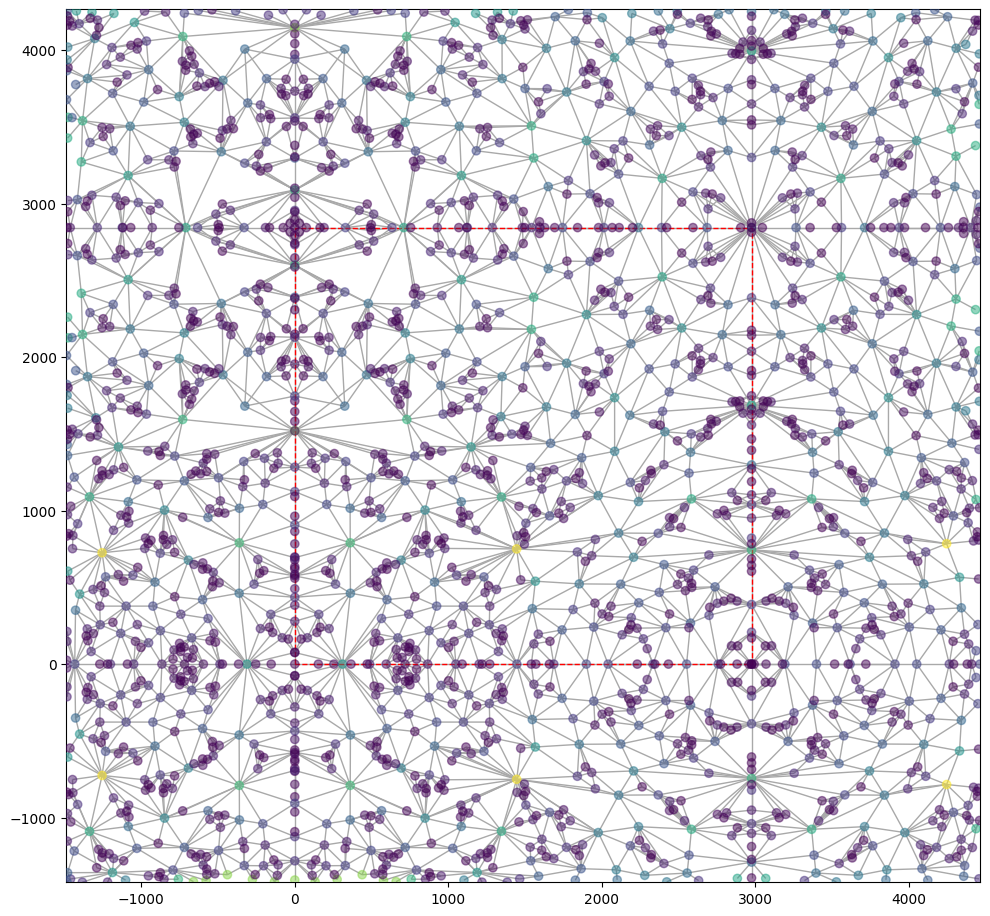

In [69]:
fig, ax = plt.subplots(1,1, figsize=(10,10), sharex=True, sharey=True); 
ax = np.atleast_1d(ax).ravel()
i = 0

nx.draw_networkx_edges(g, pos=gpos, ax=ax[i], node_size=0, edge_color='darkgray', hide_ticks=False)
ax[i].scatter(data['extcenterX'], data['extcenterY'], c=lens.loc[data.index], cmap='viridis', vmin=0, zorder=3, alpha=0.5)
ax[i].set_aspect('equal')
ax[i].plot([0,0,img.shape[1],img.shape[1],0],[0,img.shape[0],img.shape[0],0,0],ls='dashed',lw=1,c='r',zorder=1)
ax[i].set_ylim(-pady, pady+img.shape[0])
ax[i].set_xlim(-padx, padx+img.shape[1])

fig.tight_layout();

## Similar visualization

- On the left is the original image: colors are meaningless
    - Two neighboring cells could share the same color and thus would appear undistinguishable
- On the right is the adjacency matrix just looking at real cells and their actual center of mass

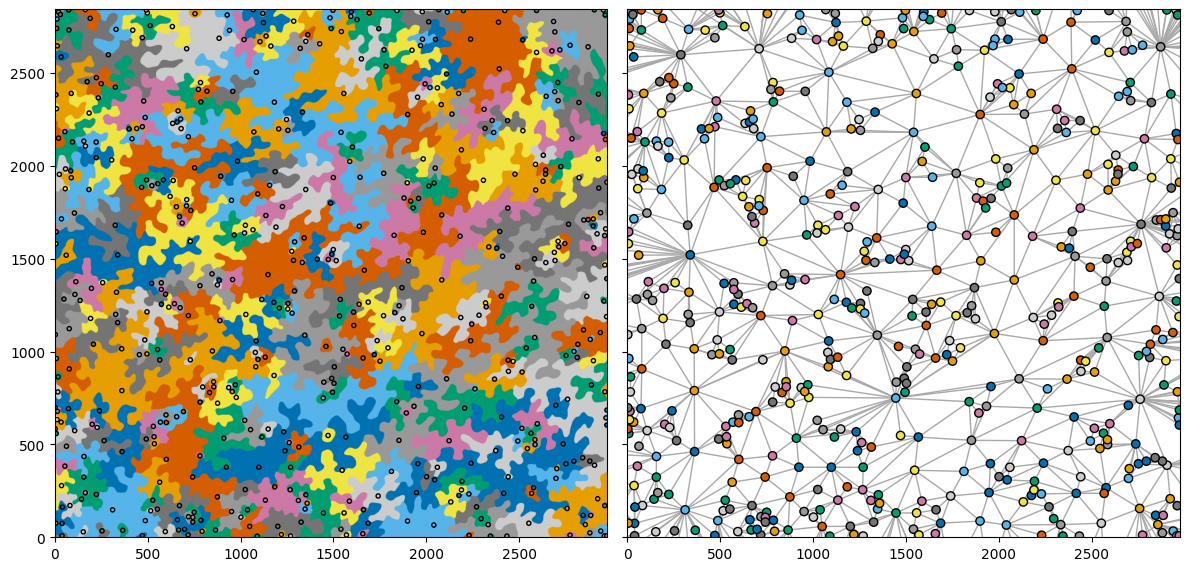

In [70]:
fig, ax = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True); 
ax = np.atleast_1d(ax).ravel()
i = 0
ax[i].imshow(img, origin='lower', cmap=cmap, vmin=0)
ax[i].scatter(*data.loc[data['true_cell'], ['centerX','centerY']].T.to_numpy(), 
              marker='.', ec='k', c=data[data['true_cell']].index, cmap=cmap, vmin=0)
i = 1
nx.draw_networkx_edges(g, pos=imgpos, ax=ax[i], node_size=0, edge_color='darkgray', hide_ticks=False)
ax[i].scatter(*data.loc[data['true_cell'], ['centerX', 'centerY']].T.to_numpy(), c=data.loc[data['true_cell']].index, cmap=cmap, vmin=0, ec='k')
ax[i].set_aspect('equal')
ax[i].set_ylim(0, img.shape[0])
ax[i].set_xlim(0, img.shape[1])

fig.tight_layout();

### Same as above but colored by lens function value

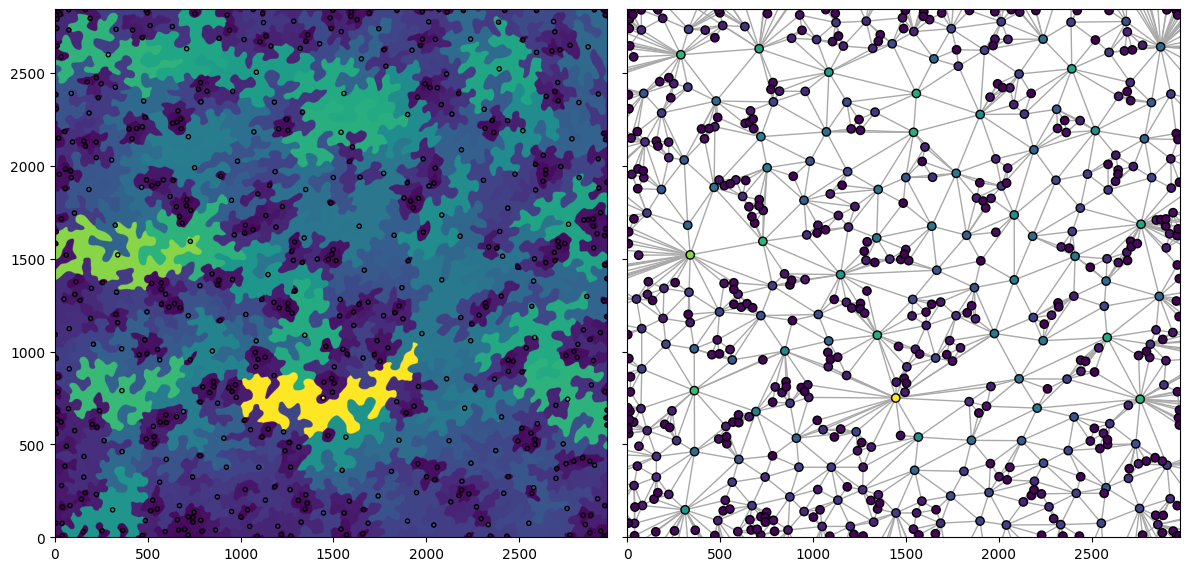

In [71]:
fig, ax = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True); 
ax = np.atleast_1d(ax).ravel()
i = 0
ax[i].imshow(mimg, origin='lower', cmap='viridis', vmin=0)
ax[i].scatter(data['centerX'], data['centerY'], marker='.', ec='k', c=lens.loc[data.index], cmap='viridis', vmin=0)
i = 1
nx.draw_networkx(g, pos=imgpos, ax=ax[i], with_labels=False, node_size=0, edge_color='darkgray', hide_ticks=False)
ax[i].scatter(data['centerX'], data['centerY'], c=lens.loc[data.index], cmap='viridis', vmin=0, ec='k')
ax[i].set_aspect('equal')
ax[i].set_ylim(0, mimg.shape[0])
ax[i].set_xlim(0, mimg.shape[1])

fig.tight_layout();

---

# Define a 2D adjacency complex based on the adjacency graph

- 0-simplices are nodes.
    - Their filtration value corresponds to the chosen lens
- 1-simplices are edges.
- 2-simplices are triangles.

The filtration value for edges and triangles is extended in a lower-star fashion.

### A word on lower-star filtrations

A lower-star filtration on a simplicial complex $X$ is a filtration extended from a function on the vertex set $f:V\to\mathbb{R}$. The lower-star filtration of $X$ at parameter $a$ is the maximal subcomplex of $X$ on the inverse image

$$f^{-1}((-\infty, a])\subset V$$

The parameter at which a simplex $[v_0,v_1,\ldots,v_n]\in X$ appears at is

$$f:[v_0,v_1,\ldots,v_n]\mapsto\max_{0\leq i\leq n}f(v_i)$$

*In other words*

A lower-star filtration starts with a function $f$ that it is defined *solely* on the vertices. Then for every other higher-dimension simplex, we'll assign it the highest filter value from its vertices.

In [72]:
# Use GUDHI to define the simplicial tree like we want it

st = gd.SimplexTree()
# insert nodes
for idx in g.nodes():
    st.insert([idx], lens.loc[idx])
# insert edges
for edge in g.edges():
    st.insert(edge, max( [ lens.loc[edge[0]], lens.loc[edge[1]]] ) )
# insert triangles
for tri in utils.all_triangles(g):
    st.insert(tri, max( [ lens.loc[tri[0]], lens.loc[tri[1]], lens.loc[tri[2]] ] ) )

## Compute persistence

With `.persistence`, we get a list of tuples:
```
[ (dimension, (birth, death) ), ... ]
```
- This list of tuples is transformed into a DataFrame for easier manipulation
- Remove the *essential* features: features with infinite death time
- Add a column `lt` for lifetime: `birth - death`
- Get the largest birth or death time `mx`: only for plot purposes.

In [73]:
pers = st.persistence(homology_coeff_field=2, min_persistence=0, persistence_dim_max=False)
df = pd.DataFrame(index=range(len(pers)), columns = ['k','b','d', 'lt'])
for i in range(len(pers)):
    k, (b,d) = pers[i]
    df.iloc[i, :] = [k, b, d, d-b]
df = df[ df['d'] < np.inf].astype(int)
mx = df.max(None)
df.head()

k      b       d     lt
0  1  79750  152076  72326
1  1  79750  152076  72326
2  1  79750  125180  45430
3  1  46676   90274  43598
4  1  46676   90274  43598

## Persistence diagram

In [80]:
mx/lens.max()

1.0

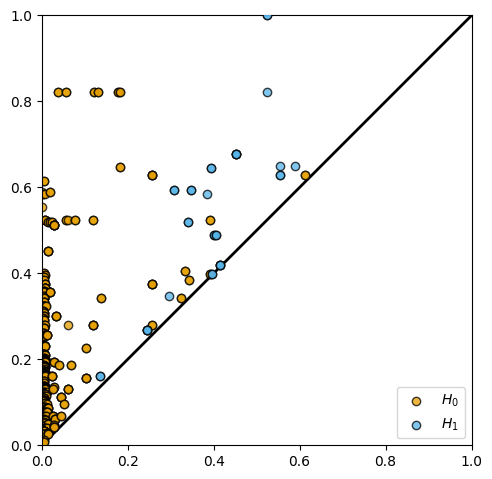

In [81]:
fig, ax = plt.subplots(1,1, figsize=(5,5), sharex=True, sharey=True); 
ax = np.atleast_1d(ax).ravel(); i = 0
ax[i].set_xlim(0,mx/lens.max())
ax[i].set_ylim(0,mx/lens.max())
ax[i].axline((0,0), slope=1, c='k', lw=2, zorder=1)
for k in [0,1]:
    foo = df[df['k'] == k]
    ax[i].scatter(foo['b']/lens.max(), foo['d']/lens.max(), c=wong[k], ec='k', label='$H_{{{}}}$'.format(k), alpha=0.75, zorder=k+2)
ax[i].legend(loc='lower right')
ax[i].set_aspect('equal')
fig.tight_layout();

---

# Persistence generators

The cool thing of lower-star filtrations is that we can go back and figure out exactly which loop in the raw image manifested as a loop in the persistence diagram.

`.lower_star_persistence_generators()` yields two lists:
- 0: pairs `(B, D)` of cells that gave birth to, and killed a topological feature when inserted in the filtration, respectively.
- 1: cells `B` that gave birth to a feature with infinite lifetime.

These two lists have two sub-lists, one per dimension.

**We will focus just on $H_1$**

In [75]:
ls_gens = st.lower_star_persistence_generators()
print(ls_gens[0][1][:5])

[[1107  225]
 [1106 1137]
 [ 469  448]
 [1924 1865]
 [1925 1866]]


### Visual example

The first pair tells us that a cycle was born when cell $B$ was inserted and killed when $D$ came into the picture

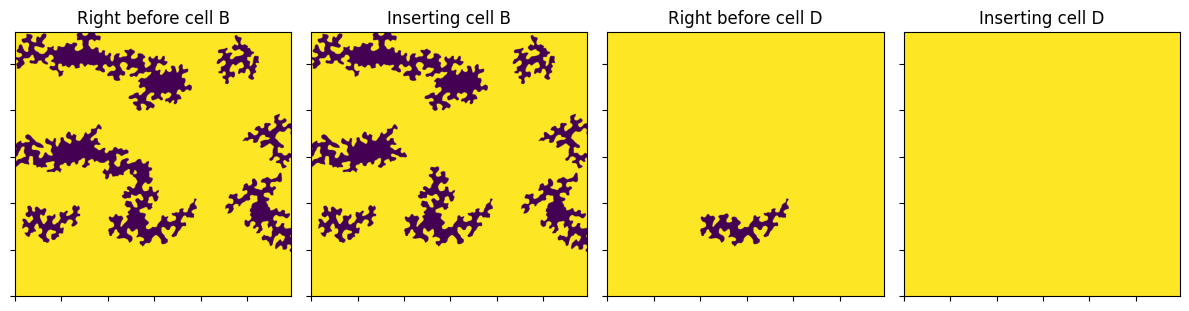

In [77]:
# Birth-Death cell labels
B, D = ls_gens[0][1][-1]

# birth-death times
b,d = lens.loc[[B,D]]


fig, ax = plt.subplots(1,4, figsize=(12,5), sharex=True, sharey=True); 
ax = np.atleast_1d(ax).ravel(); i = 0
ax[i].imshow(mimg < b-1, origin='lower', cmap='viridis', vmin=0, vmax=1); i += 1
ax[i].imshow(mimg <= b, origin='lower', cmap='viridis', vmin=0, vmax=1); i += 1
ax[i].imshow(mimg < d-1, origin='lower', cmap='viridis', vmin=0, vmax=1); i += 1
ax[i].imshow(mimg <= d, origin='lower', cmap='viridis', vmin=0, vmax=1); i += 1

title = ['Right before cell B', 'Inserting cell B', 'Right before cell D', 'Inserting cell D']
for i in range(len(ax)):
    ax[i].tick_params(labelleft=False, labelbottom=False)
    ax[i].set_title(title[i])

fig.tight_layout();

### Figure out exactly the cycle represented in the persistence diagram

- The cells $B$ and $D$ don't tell us the exact cycle that was formed and then sealed.
- We need to do more work to retrieve that info.

In [82]:
# Empty list to store the persistent cycles
generator_cycle = []; 

# Loop through the persistence generators
for (B,D) in ls_gens[0][1]:
    # Only consider persistence pairs where at least one cell is real
    if (B <= maxcell) | (D <= maxcell):

        # Get the filtration step at which the loop was born and killed
        b,d = lens.loc[[B,D]]
        print((B,D), st.filtration([B]), st.filtration([D]), st.filtration([D]) - st.filtration([B]), sep='\t')
        
        # Get the subgraph right after B was inserted
        subb = utils.redux_subgraph(g, lens, B)

        # Get the shortest path that connects B and D
        # Use only nodes and edges with lens value between b and d
        bd_path = utils.birth_death_path(g, lens, B, D)

        # Get the subgraph only considering nodes inserted between B and D
        # Remove the path between B and D
        subd = utils.redux_subgraph(g, lens, D, B, False)
        #subd.remove_edges_from([(bd_path[i], bd_path[i+1]) for i in range(len(bd_path)-1) ])
        subd.remove_nodes_from([B])

        # Do a breadth-first-seach exploration starting from D
        spath = list(nx.bfs_layers(subd, D))
        spath = dict(zip(range(1,1+len(spath)),spath))
        spath[0] = bd_path[1:]

        # Consider all the cycles containing B in the subgraph when only considering vertices that are neighbors of D
        # Consider also neighbors of neighbors of D if no cycle found at first
        # Consider also neighbors or neighbors of neighbors of D if still no cycle is found
        # etc...
        simple_cycles = utils.generating_cycles(subb, B, neighbors, spath)
        
        # The final cycle is the longest one
        if len(simple_cycles) > 0:
            amax = np.argmax(list(map(len, simple_cycles)))
            cycle = copy.deepcopy(simple_cycles[amax])
            cycle.append(cycle[0])
            generator_cycle.append(cycle)
        else:
            print('No cycles found!')

(1107, 225)	20689.0	24485.0	3796.0
(469, 448)	37265.0	40948.0	3683.0
(1982, 495)	44931.0	52869.0	7938.0
(327, 305)	60406.0	60489.0	83.0
(115, 124)	63028.0	63664.0	636.0
(352, 359)	60854.0	74420.0	13566.0
(721, 48)	51687.0	79119.0	27432.0
(1762, 447)	58594.0	88874.0	30280.0
(401, 409)	52984.0	90274.0	37290.0
(179, 263)	84486.0	95581.0	11095.0
(1697, 454)	59810.0	98208.0	38398.0
(799, 35)	89719.0	98835.0	9116.0
(163, 58)	68827.0	103117.0	34290.0
(1053, 23)	79750.0	125180.0	45430.0
(199, 221)	79750.0	152076.0	72326.0


### For visualization purposes:

- Make a DataFrame with birth and death generators, birth and death time, and lifetime
- Define a colormap based on lifetime
- Discard features that live completely in mirrored space

In [99]:
hk = pd.DataFrame(columns=['B','D','b','d','lt'])
for j in range(len(ls_gens[0][1])):
    B, D = ls_gens[0][1][j]
    if (B <= maxcell) | (D <= maxcell):
        B,D = ls_gens[0][1][j]
        b,d = lens.loc[[B,D]]
        lt = d - b
        hk.loc[j] = [B,D,b,d,lt]
        
ltmax = hk['lt'].max()

# The smallest possible value is 55, not 0
minval = 1

cymap = mpl.colormaps['autumn_r']
hk['c'] = [cymap(x) for x in ((255-minval)*hk['lt']/ltmax).round().astype(int)+minval]
cymap = mpl.colormaps['autumn']
hk['cr'] = [cymap(x) for x in ((255-minval)*hk['lt']/ltmax).round().astype(int)+minval]
hk.index = range(len(hk))
hk

B      D        b         d       lt  \
0   1107.0  225.0  20689.0   24485.0   3796.0   
1    469.0  448.0  37265.0   40948.0   3683.0   
2   1982.0  495.0  44931.0   52869.0   7938.0   
3    327.0  305.0  60406.0   60489.0     83.0   
4    115.0  124.0  63028.0   63664.0    636.0   
5    352.0  359.0  60854.0   74420.0  13566.0   
6    721.0   48.0  51687.0   79119.0  27432.0   
7   1762.0  447.0  58594.0   88874.0  30280.0   
8    401.0  409.0  52984.0   90274.0  37290.0   
9    179.0  263.0  84486.0   95581.0  11095.0   
10  1697.0  454.0  59810.0   98208.0  38398.0   
11   799.0   35.0  89719.0   98835.0   9116.0   
12   163.0   58.0  68827.0  103117.0  34290.0   
13  1053.0   23.0  79750.0  125180.0  45430.0   
14   199.0  221.0  79750.0  152076.0  72326.0   

                                       c  \
0    (1.0, 0.9450980392156862, 0.0, 1.0)   
1    (1.0, 0.9450980392156862, 0.0, 1.0)   
2    (1.0, 0.8862745098039215, 0.0, 1.0)   
3     (1.0, 0.996078431372549, 0.0, 1.0)   
4    (1.0, 0.9882352941176471, 0.0, 1.0)   
5     (1.0, 0.807843137254902, 0.0, 1.0)   
6    (1.0, 0.6196078431372549, 0.0, 1.0)   
7     (1.0, 0.580392156862745, 0.0, 1.0)   
8   (1.0, 0.48235294117647065, 0.0, 1.0)   
9    (1.0, 0.8431372549019608, 0.0, 1.0)   
10   (1.0, 0.4666666666666667, 0.0, 1.0)   
11   (1.0, 0.8705882352941177, 0.0, 1.0)   
12   (1.0, 0.5254901960784314, 0.0, 1.0)   
13   (1.0, 0.3686274509803922, 0.0, 1.0)   
14                  (1.0, 0.0, 0.0, 1.0)   

                                       cr  
0   (1.0, 0.054901960784313725, 0.0, 1.0)  
1   (1.0, 0.054901960784313725, 0.0, 1.0)  
2    (1.0, 0.11372549019607843, 0.0, 1.0)  
3    (1.0, 0.00392156862745098, 0.0, 1.0)  
4   (1.0, 0.011764705882352941, 0.0, 1.0)  
5    (1.0, 0.19215686274509802, 0.0, 1.0)  
6     (1.0, 0.3803921568627451, 0.0, 1.0)  
7     (1.0, 0.4196078431372549, 0.0, 1.0)  
8     (1.0, 0.5176470588235293, 0.0, 1.0)  
9     (1.0, 0.1568627450980392, 0.0, 1.0)  
10    (1.0, 0.5333333333333333, 0.0, 1.0)  
11   (1.0, 0.12941176470588234, 0.0, 1.0)  
12    (1.0, 0.4745098039215686, 0.0, 1.0)  
13    (1.0, 0.6313725490196078, 0.0, 1.0)  
14                   (1.0, 1.0, 0.0, 1.0)

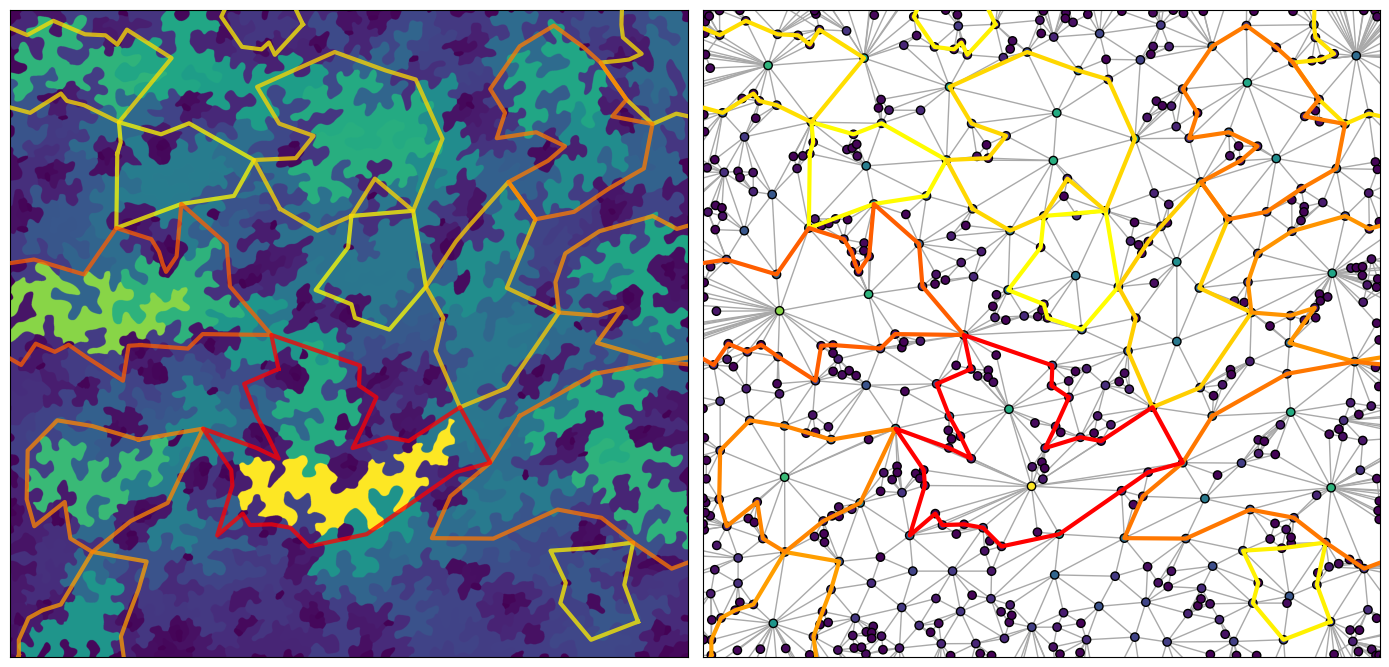

In [101]:
fig, ax = plt.subplots(1,2, figsize=(14, 7), sharex=True, sharey=True); 
ax = np.atleast_1d(ax).ravel()
i = 0
ax[i].imshow(mimg, origin='lower', cmap='viridis', vmin=0)
for j in range(len(generator_cycle)):
    ax[i].plot(*data.loc[generator_cycle[j], ['centerX','centerY']].T.to_numpy(), c=hk.loc[j,'c'], lw=3, zorder=3, alpha=0.75)
i += 1
nx.draw_networkx_edges(g, pos=imgpos, ax=ax[i], node_size=0, edge_color='darkgray', hide_ticks=False)
ax[i].scatter(data['centerX'], data['centerY'], c=lens, cmap='viridis', vmin=0, ec='k', zorder=2)
for j in range(len(generator_cycle)):
    ax[i].plot(*data.loc[generator_cycle[j], ['centerX','centerY']].T.to_numpy(), c=hk.loc[j,'c'], lw=3, zorder=3, alpha=1)
for i in range(len(ax)):
    ax[i].set_ylim(0, img.shape[0])
    ax[i].set_xlim(0, img.shape[1])
    ax[i].set_aspect('equal')
    ax[i].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

fig.tight_layout();

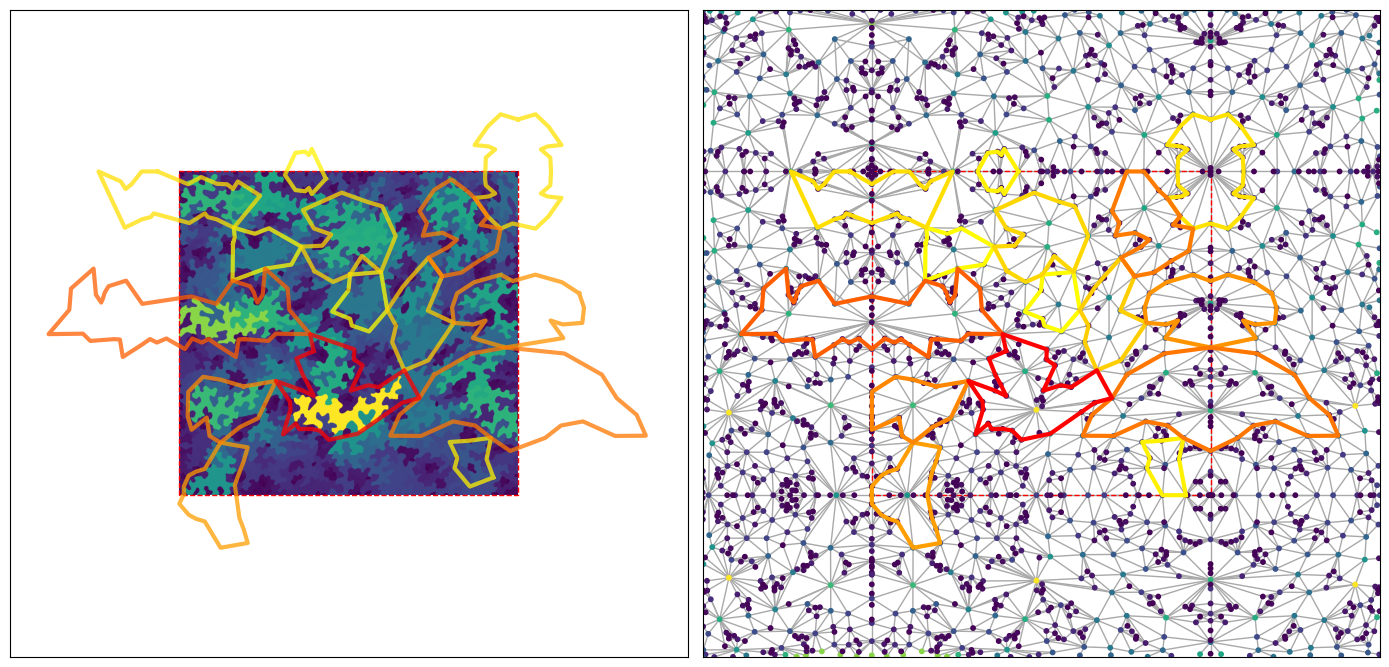

In [102]:
fig, ax = plt.subplots(1,2, figsize=(14, 7), sharex=True, sharey=True); 
ax = np.atleast_1d(ax).ravel()
i = 0
ax[i].imshow(mimg, origin='lower', cmap='viridis', vmin=0)
for j in range(len(generator_cycle)):
    ax[i].plot(*data.loc[generator_cycle[j], ['centerX','centerY']].T.to_numpy(), c=hk.loc[j,'c'], lw=3, zorder=3, alpha=0.75)
i += 1
nx.draw_networkx_edges(g, pos=gpos, ax=ax[i], node_size=0, edge_color='darkgray', hide_ticks=False)
ax[i].scatter(data['extcenterX'], data['extcenterY'], c=lens, cmap='viridis', vmin=0, zorder=2, s=10)
for j in range(len(generator_cycle)):
    ax[i].plot(*data.loc[generator_cycle[j], ['extcenterX','extcenterY']].T.to_numpy(), c=hk.loc[j,'c'], lw=3, zorder=3, alpha=1)
for i in range(len(ax)):
    ax[i].set_aspect('equal')
    ax[i].plot([0,0,img.shape[1],img.shape[1],0],[0,img.shape[0],img.shape[0],0,0],ls='dashed',lw=1,c='r',zorder=1)
    ax[i].set_ylim(-pady, pady+img.shape[0])
    ax[i].set_xlim(-padx, padx+img.shape[1])
    ax[i].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

fig.tight_layout();

---

# IGNORE



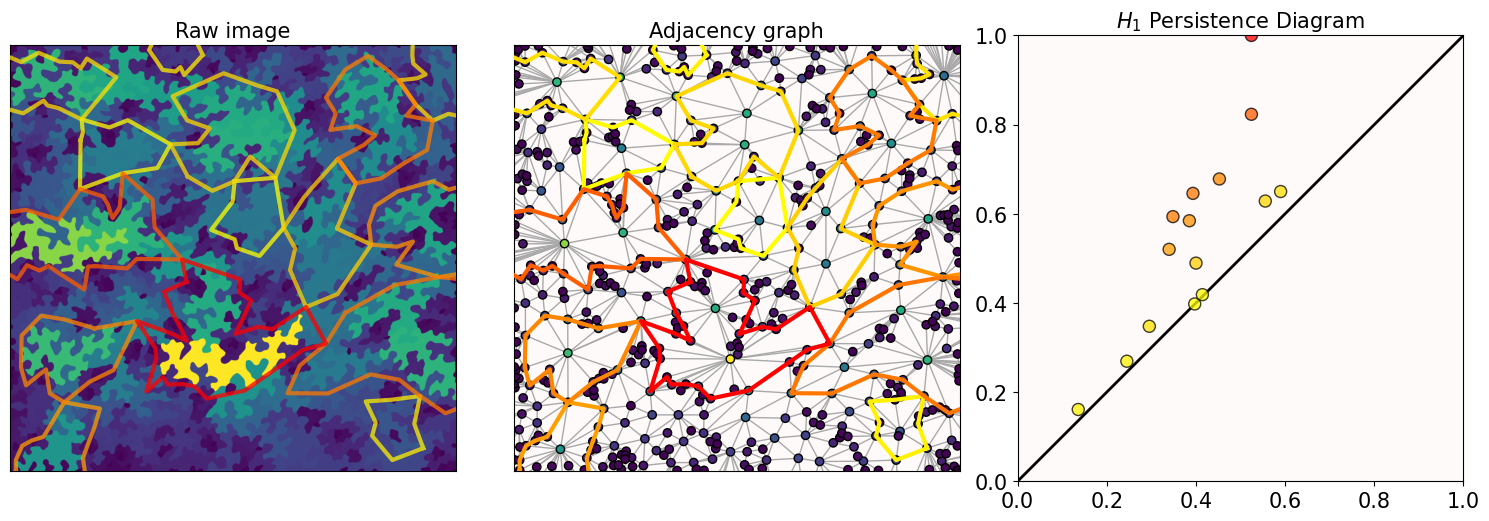

In [104]:
fig, ax = plt.subplots(1,3, figsize=(15, 5)); 
ax = np.atleast_1d(ax).ravel()

i = 0
ax[i].imshow(mimg, origin='lower', cmap='viridis', vmin=0)
for j in range(len(generator_cycle)):
    ax[i].plot(*data.loc[generator_cycle[j], ['centerX','centerY']].T.to_numpy(), c=hk.loc[j,'c'], lw=3, zorder=3, alpha=0.75)

i += 1
nx.draw_networkx_edges(g, pos=imgpos, ax=ax[i], node_size=0, edge_color='darkgray', hide_ticks=False)
ax[i].scatter(data['centerX'], data['centerY'], c=lens, cmap='viridis', vmin=0, ec='k', zorder=2)
for j in range(len(generator_cycle)):
    ax[i].plot(*data.loc[generator_cycle[j], ['centerX','centerY']].T.to_numpy(), c=hk.loc[j,'c'], lw=3, zorder=3, alpha=1)

for i in range(2):
    ax[i].set_ylim(0, img.shape[0])
    ax[i].set_xlim(0, img.shape[1])
    ax[i].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
i = -1
ax[i].set_xlim(0,mx/lens.max())
ax[i].set_ylim(0,mx/lens.max())
ax[i].axline((0,0), slope=1, c='k', lw=2, zorder=1)
ax[i].scatter(hk['b']/lens.max(),hk['d']/lens.max(), c=hk['c'], ec='k', alpha=0.75, zorder=2, s=75)
ax[i].tick_params(labelsize=15)

title = ['Raw image', 'Adjacency graph', '$H_1$ Persistence Diagram']
for i in range(len(ax)):
    ax[i].set_title(title[i], fontsize=15)
    ax[i].set_aspect('equal')
    ax[i].set_facecolor('snow')

fig.tight_layout();
plt.savefig(bname + '.png', format='png', dpi=200, bbox_inches='tight')

In [21]:
bname

'segmentation'

In [56]:
#(34, 279)	18669.0	150366.0	131697.0
reload(utils)
B,D = 1346, 23
print((B,D), st.filtration([B]), st.filtration([D]), st.filtration([D]) - st.filtration([B]), sep='\t')
#bthreshold = lens.loc[B]
#nodes = lens[lens <= bthreshold].index
#subb = g.subgraph(nodes)
subb = utils.redux_subgraph(g, lens, B)
bd_path = utils.birth_death_path(g, lens, B, D)
subd = utils.redux_subgraph(g, lens, D, B, False)
subd.remove_nodes_from([B])

spath = list(nx.bfs_layers(subd, D))
spath = dict(zip(range(1,1+len(spath)),spath))
spath[0] = bd_path[1:]

simple_cycles = utils.generating_cycles(subb, B, neighbors, spath)
amax = np.argmax(list(map(len, simple_cycles)))
cycle = copy.deepcopy(simple_cycles[amax])

(1346, 23)	79750.0	125180.0	45430.0


In [57]:
simple_cycles

[[772,
  703,
  654,
  22,
  55,
  68,
  87,
  92,
  120,
  133,
  146,
  188,
  199,
  198,
  187,
  115,
  165,
  150,
  122,
  94,
  77,
  28,
  738,
  801,
  914,
  884,
  1262,
  1338,
  1346,
  1041,
  978,
  903,
  795],
 [772,
  703,
  654,
  22,
  55,
  68,
  87,
  92,
  120,
  133,
  146,
  188,
  199,
  198,
  187,
  115,
  165,
  150,
  122,
  94,
  77,
  28,
  738,
  801,
  914,
  884,
  1262,
  1338,
  1346,
  1270,
  1041,
  978,
  903,
  795],
 [772,
  703,
  654,
  22,
  55,
  68,
  87,
  92,
  120,
  133,
  146,
  188,
  199,
  198,
  187,
  115,
  165,
  150,
  122,
  94,
  77,
  28,
  738,
  801,
  914,
  1063,
  1109,
  1104,
  1134,
  884,
  1262,
  1338,
  1346,
  1041,
  978,
  903,
  795],
 [772,
  703,
  654,
  22,
  55,
  68,
  87,
  92,
  120,
  133,
  146,
  188,
  199,
  198,
  187,
  115,
  165,
  150,
  122,
  94,
  77,
  28,
  738,
  801,
  914,
  1063,
  1109,
  1104,
  1134,
  884,
  1262,
  1338,
  1346,
  1270,
  1041,
  978,
  903,
  795],
 [772,
 

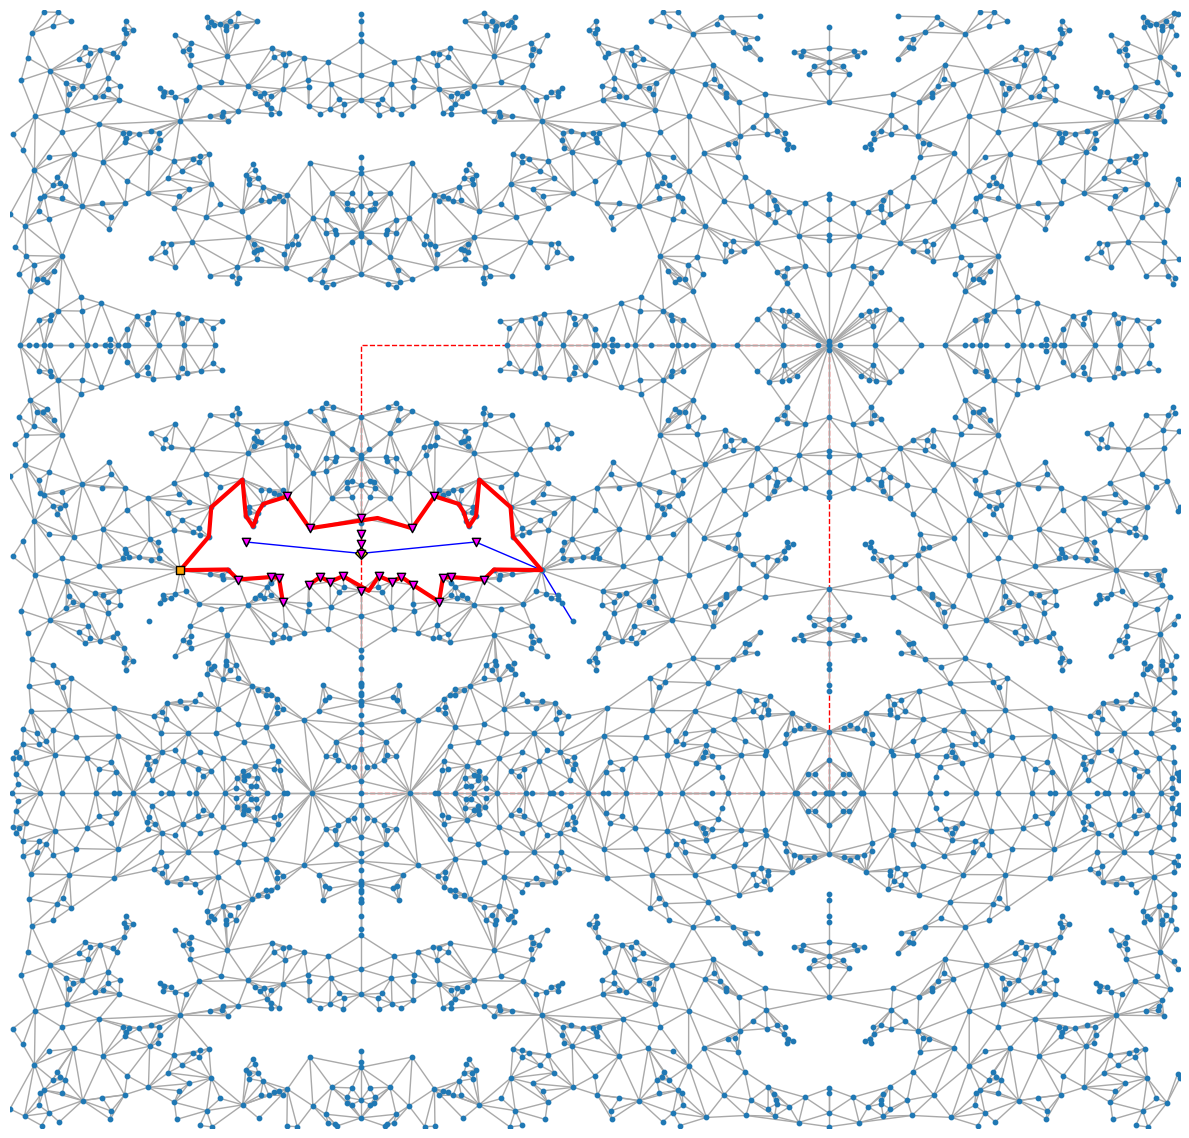

In [58]:
fig, ax = plt.subplots(1,1, figsize=(12, 12), sharex=True, sharey=True); 
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].set_aspect('equal')
ax[i].plot([0,0,img.shape[1],img.shape[1],0],[0,img.shape[0],img.shape[0],0,0],ls='dashed',lw=1,c='r',zorder=1)
ax[i].set_ylim(-pady, pady+img.shape[0])
ax[i].set_xlim(-padx, padx+img.shape[1])


i = 0
subpos = {k: gpos[k] for k in subb.nodes()}
nx.draw_networkx(subb, pos=subpos, ax=ax[i], edge_color='darkgray', hide_ticks=False, with_labels=False, node_size=10)
sudpos = {k: gpos[k] for k in subd.nodes()}
nx.draw_networkx(subd, pos=sudpos, ax=ax[i], edge_color='blue', hide_ticks=False, with_labels=False, node_size=10)
#ax[i].scatter(data.loc[nodes, 'centerX'], data.loc[nodes, 'centerY'], c='dodgerblue', ec='k')
ax[i].scatter(data.loc[B, 'extcenterX'], data.loc[B, 'extcenterY'], c='orange', ec='k', marker='s', zorder=5)
ax[i].scatter(data.loc[D, 'extcenterX'], data.loc[D, 'extcenterY'], c='yellow', ec='k', marker='D', zorder=5)

ax[i].plot(*data.loc[cycle, ['centerX','centerY']].T.to_numpy(), c='r', lw=3, zorder=3, alpha=1)
#ax[i].scatter(*data.loc[np.unique(ls_gens[1][1]), ['centerX', 'centerY'] ].T.to_numpy(), c='lime', ec='k', marker='^', zorder=5)
ax[i].scatter(*data.loc[neighbors[D], ['extcenterX', 'extcenterY'] ].T.to_numpy(), c='fuchsia', ec='k', marker='v', zorder=5)
ax[i].axis('off')
fig.tight_layout();

In [50]:
spath

{1: [23], 2: [109, 862], 3: [199], 4: [251], 0: [862, 23]}